<a href="https://colab.research.google.com/github/kdidi99/ml_advanced_hd/blob/main/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4

## Preliminaries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = 'cuda'
    print("Cuda available")
else:
    device = 'cpu'
    

batch_size = 128

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Cuda available


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [20]:
#Converts label idx (n labels total) into one-hot encoding
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx, 1)

    return onehot

#example:
idx2onehot(3*torch.ones(7, dtype=torch.long),n=10)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## Basics/Repetition  of VAE

In the lecture we have shown that $$\log p^*(x^{(i)}) \ge  -  D_{KL}[p_E(z \mid x^{(i)}) \| p(z)] +\mathbb{E}_{z\sim p_E(z \mid x^{(i)})} [\log p_D (x^{(i)} \mid z)] = -\mathcal{L}(D, E, x^{(i)}),$$
where $x^{(i)}\in\mathbb{R}^D$ is the $i$-th training instance (since the pixel values of MNIST images are in the range 0...1, we even have $x^{(i)}\in[0,1]^D$ in this case). The LHS is the logarithm of the true data distribution, and the RHS is termed the "evicence lower bound" (ELBO).

We call $p_E(z \mid x)$ the encoder and $p_D( x \mid z)$ the decoder. Both will be represented by neural networks. Our goal is to approximate $p^*(x)$ as well as possible by maximizing the ELBO or equivalently minimizing its negation. Specifically, we minimize $\mathcal{L}(D, E, x^{(i)})$ with respect to the parameters of the decoder network $D$ and the encoder network $E$ via gradient descent over all training instances $i$. 

In order to estimate the negative ELBO, we approximate the expectation w.r.t. $z$ by its average over $L$ instances:
\begin{align} \hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)\end{align} 
where $z^{(i,l)} \sim p_E(z \mid x^{(i)}) $. By construction of a VAE, $p_E(z \mid x^{(i)})$ is a Gaussian distribution whose mean $\mu^{(i)}=\mu_E(x^{(i)})$ and standard deviation $\sigma^{(i)}=\sigma_E(x^{(i)})$ are computed by the encoder network. For fixed $x^{(i)}$, we can draw samples $z^{(i,l)}$ from this code distribution by means of the reparametrization trick: 
$$z^{(i,l)}\sim \mathcal{N}\big(\mu^{(i)}, \text{diag}(\sigma^{(i)})^2\big) \Leftrightarrow  z^{(i,l)} = \mu^{(i)} + \epsilon_l \cdot \sigma^{(i)}$$ 
with $\epsilon_l\sim\mathcal{N}(0, \mathbb{I})$. Note that $\mu^{(i)}$, $\sigma^{(i)}$, and $\epsilon_l$ are vectors of length equal to the dimension $J$ of the latent space, and $\epsilon_l \cdot \sigma^{(i)}$ is element-wise multiplication. In practice, $L=1$ is usually sufficient so that the average over index $l$ becomes trivial.

Furthermore, we assume that the latent prior is a standard normal distribution, i.e. $p(z) = \mathcal{N}(0, \mathbb{I})$. The KL-term for the two multivariate normal distributions can then be computed analytically:
$$ D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right] = \frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) $$

Likewise, we consider $p_D(x \mid z)$ as a Gaussian distribution with mean $\mu_D(z)$ and fixed covariance matrix $\sigma_G^2\cdot \mathbb{I}$ (i.e. $\sigma_G$ is the fixed noise standard deviation):
$$ p_G(x \mid z) = \mathcal{N}\big(\mu_D(z), \sigma_G^2\cdot\mathbb{I}\big)$$
To ensure that $\mu_D(z) \in [0,1]^D$ holds for reconstructed images (without noise), the decoder's output layer should use the sigmoid activation function. The second term in the negated ELBO (the negative log-likelihood) now reduces to the squared loss:
$$-\log p_D(x^{(i)} \mid z^{(i,l)}) = \frac{||x^{(i)} - \mu_D(z^{(i,l)})||^2_2}{2 \sigma_G^2}  + \text{const.}$$
The additive constant has no influence on the training optimimum and can be dropped. $\sigma_G$ can be used as a hyperparameter to balance the two loss terms.

For a batch of samples $X = (x^{(1)}, \dots, x^{(M)})$, we finally get the negated ELBO as:
\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) \\+& \frac{1}{L} \sum_{l=1}^L \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2\sigma_G^2}\Big]\end{align}
Training is performed by gradient descent on this loss.

## Task 1: Implementation of VAE and CVAE

Complete the code below. The CVAE class consists of three parts
* The Encoder class that implements $p_E (z \mid x, y)$,
* The Decoder class which implements $p_D (x \mid z, y)$ and
* The actual CVAE class that combines both encoder and decoder.

The conditioning variable $y$ holds the labels, e.g. 0...9 for MNIST digits. It is added as an additional network input, i.e. the encoder computes $\mu_E(x^{(i)}, y^{(i)})$ and $\sigma_E(x^{(i)}, y^{(i)})$. The decoder produces the reconstruction `recon_x`=$\mu_D(z^{(i)}, y^{(i)})$, where $z^{(i)}$ is sampled using the reparametrization trick explained above. 

Implement all three classes. The arguments and outputs for each method are given in the docstrings. Make sure the CVAE class implements both the conditional VAE (CVAE) and the plain VAE, where the latter is obtained if the number of labels is just 1. 

tensor(90.0171)
tensor(90.0171)


In [91]:
class CVAE(nn.Module):

    def __init__(self, inp_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim, num_labels=10, conditional=False):
        """
        Arguments:
            inp_dim (int): dimension of input,
            encoder_layer_sizes (list[int]): list of the sizes of the encoder layers,
            decoder_layer_sizes (list[int]): list of the sizes of the decoder layers,
            latent_dim (int): dimension of latent space/bottleneck,
            num_labels (int): amount of labels (important for conditional VAE),,
            conditional (bool): True if CVAE, else False

        """
        
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        
        self.encoder = Encoder(encoder_layer_sizes, latent_dim, num_labels, conditional)
        self.decoder = Decoder(decoder_layer_sizes, latent_dim, num_labels, conditional)
        
    def forward(self, x, c=None):
        """
        Forward Process of whole VAE/CVAE. 
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output: recon_x, means, log_var
            recon_x: see explanation on second part of estimator above,
            means: output of encoder,
            log_var: output of encoder (logarithm of variance)
        """

        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        
        batch_size = x.size(0)

        x = x.view(-1,784)
        
        means, log_var = self.encoder(x,c)
        #use reparameterization to sample latent z from encoder distribution
        epsilon = torch.randn([batch_size, latent_dim])
        epsilon = epsilon.to(device)
        std = torch.sqrt(torch.exp(log_var))
        z = means + epsilon * std
        recon_x = self.decoder(z, c)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return recon_x, means, log_var
        
    def sampling(self, n=2, c=None):
        """
        Generates new samples by feeding a random latent vector to the decoder.
        Arguments:
            n (int): amount of samples 
            c      : None or tensor of dimension (batch_size, 1) (labels to condition on)
        Output:
            x_sampled: n randomly sampled elements of the output distribution
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        z = torch.randn([n, self.latent_dim])
        z = z.to(device)

        x_sampled = self.decoder(z,c)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
        return x_sampled 
    
class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):
        super(Encoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the encoder,
            latent_dim (int): dimension of latent space, i.e. dimension out output of the encoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        """
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #hint: if conditional the input layersize needs to be increased for the additional one-hot vector input
        self.conditional = conditional
        if self.conditional == True:
          layer_sizes[0] = layer_sizes[0] + num_labels

        #construct sequential container to hold all layers
        self.network = nn.Sequential()

        #implement all following layers
        for idx,layer in enumerate(layer_sizes):
          if idx+1<len(layer_sizes):
            self.network.add_module(name=f"layer{idx+1}", module = nn.Linear(layer_sizes[idx], layer_sizes[idx+1]))
            self.network.add_module(name=f"relu{idx+1}", module = nn.ReLU())

        #implementation of last layer (output) with sigmoid function
        self.layer_means = nn.Linear(layer_sizes[-1], latent_dim)
        self.layer_log_var = nn.Linear(layer_sizes[-1], latent_dim)
        

        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
    
    def forward(self, x, c=None):  
        """
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output:
            means: tensor of dimension (batch_size, latent_dim),
            log_var: tensor of dimension (batch_size, latent_dim)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #Hint: convert condition c into one-hot encoding
        #convert c and concatenate it to x
        if self.conditional == True:
          c = idx2onehot(c ,n=10)
          c = c.to(device)
          x = torch.cat((x,c), dim=-1)

        #pass input x through whole network container (excluding last layers)
        x = self.network(x)
        #get final output
        means = self.layer_means(x)
        log_vars = self.layer_log_var(x)
        
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################        
        return means, log_vars
    
    
class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):     
        super(Decoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the decoder,
            latent_dim (int): dimension of latent space, i.e. dimension out input of the decoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        Output:
            x: Parameters of gaussian distribution; only mu (see above)
        """

        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #hint: if conditional is True, the input layersize needs to be increased for the additional one-hot vector input
        #implementation similar to encoder
        self.conditional = conditional
        if self.conditional == True:
          latent_output = latent_dim + num_labels
        else:
          latent_output = latent_dim

        #construct sequential container to hold all layers
        self.network = nn.Sequential()

       #implement first layer
        self.layer0 = nn.Linear(latent_output, layer_sizes[0])

        #implement all following layers
        for idx,layer in enumerate(layer_sizes):
          if idx+1<len(layer_sizes):
            self.network.add_module(name=f"layer{idx+1}", module = nn.Linear(layer_sizes[idx], layer_sizes[idx+1]))
            self.network.add_module(name=f"relu{idx+1}", module = nn.ReLU())

        #implementation of last layer
        self.layer_means = nn.Sigmoid()

        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
            
    def forward(self, z, c=None):
        """
        Argumetns:
            z: tensor of dimension (batch_size, latent_dim)
            c: None or tensor of dimension (batch_size, 1)
        Outputs:
            x: mu of gaussian distribution (reconstructed image from latent code z)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #Hint: convert condition c into one-hot encoding
        #convert c and concatenate it to z
        if self.conditional == True:
          c = idx2onehot(c ,n=10)
          c = c.to(device)
          z = torch.cat((z,c), dim=-1)

        #pass input z through whole network container
        z = self.layer0(z)
        x = self.network(z)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return x

### Loss Function

We want to minimize the negated ELBO loss:
$$\hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)$$
where $L=1$. The `loss_function` should implement this estimator, expanding the two terms as explained above.
* Implement the loss function
* Comment/explain how your code arises from the formula above.

Hint: Use the following choice of hyperparameter $\sigma_G = 1$.

In [75]:
# Implement the Loss function for the VAE/CVAE
def loss_function(recon_x, x, mu, log_var):
    """
    Arguments:
        recon_x: reconstruced input
        x: input,
        mu, log_var: parameters of posterior (distribution of z given x)
    """
    ################################
    # TODO: YOUR CODE STARTS BELOW #
    ################################
    x = x.view(-1, 28*28)

    loss = 0.5 * torch.sum(mu**2 + log_var.exp() - log_var - 1)/x.shape[0] + torch.mean(0.5 * torch.sum((x-recon_x)**2, 1))

    return loss
    
    ################################
    #     YOUR CODE ENDS HERE      #
    ################################

Code arises in the following way:


For a batch of samples $X = (x^{(1)}, \dots, x^{(M)})$, we finally get the negated ELBO as:
\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) \\+& \frac{1}{L} \sum_{l=1}^L \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2\sigma_G^2}\Big]\end{align}
Training is performed by gradient descent on this loss.

For choosing $L=1$ and $\sigma_G^2 = 1$, this simplifies to: 

\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) \\+& \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2}\Big]\end{align}

The second term is implemented in the torch.mean function, summing over the first dimension of x and recon_x.

The first term is implemented by calculating std from log_var and then summing over the first dimension.

I implemented not directly the fomula written above, but the one in the lecture where we use the variance also in the log and not the std as written in the formula given here since this formula gave a bad performance.

Exercise sheet formula: 


\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)})^2 - 1\right) \\+& \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2}\Big]\end{align}

<font color='blue'><strong>Which of the formulas is correct, the one from the lecture or the one from the exercise sheet? I also needed to divide over the number of samples in the kld term which was not present in the formula, should this also be added to the formula?</strong></font>


### Training of VAE
Before we can do funny things with our VAE, we train it with a bottleneck size of two. If everything has been implemented correctly, you should obtain an VAE after a few epochs that is able to generate recognizable MNIST samples. 

The amount of layers as well as their dimensions do not have to be changed throughout this exercise. Better results might by achieved by searching for different hyperparameters.
* Simply run the code to train the VAE

In [79]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 2 
vae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training of the VAE
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
epochs = 15 
for epoch in range(epochs):
    train(epoch)  

Train Epoch: 0 [0/60000 (0%)]	Loss: 21.018410
Train Epoch: 0 [12800/60000 (21%)]	Loss: 12.759501
Train Epoch: 0 [25600/60000 (43%)]	Loss: 13.268714
Train Epoch: 0 [38400/60000 (64%)]	Loss: 11.612599
Train Epoch: 0 [51200/60000 (85%)]	Loss: 13.320406
====> Epoch: 0 Average loss: 0.2015
Train Epoch: 1 [0/60000 (0%)]	Loss: 11.908723
Train Epoch: 1 [12800/60000 (21%)]	Loss: 11.940440
Train Epoch: 1 [25600/60000 (43%)]	Loss: 12.110125
Train Epoch: 1 [38400/60000 (64%)]	Loss: 11.354757
Train Epoch: 1 [51200/60000 (85%)]	Loss: 12.416795
====> Epoch: 1 Average loss: 0.1885
Train Epoch: 2 [0/60000 (0%)]	Loss: 11.523178
Train Epoch: 2 [12800/60000 (21%)]	Loss: 11.387609
Train Epoch: 2 [25600/60000 (43%)]	Loss: 11.778190
Train Epoch: 2 [38400/60000 (64%)]	Loss: 11.111639
Train Epoch: 2 [51200/60000 (85%)]	Loss: 12.146364
====> Epoch: 2 Average loss: 0.1842
Train Epoch: 3 [0/60000 (0%)]	Loss: 11.174753
Train Epoch: 3 [12800/60000 (21%)]	Loss: 11.203423
Train Epoch: 3 [25600/60000 (43%)]	Loss: 11.6

### Sanity Check VAE
Your model should be able to reproduce the input image, i.e. the output of the VAE should look similar to be input. 
 
* Run the code to check if your model worked
* How are the reconstructions different from the original?

Original             Reconstructed


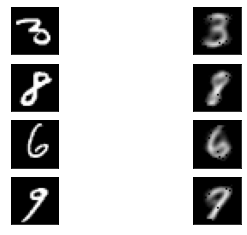

In [84]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg, vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])

Answer: The reconstructions are blurrier than the original digits; they also do not capture exact characteristics of the input writing, but represent more of an idealized digit.

Your model should be able to generate images that look similar to the samples of the MNIST dataset.
* Run the code
* Describe what you see

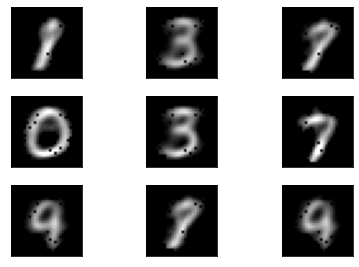

In [85]:
for i in range(1, 10):
    plt.subplot(3,3,i)
    sample = vae.sampling(n=1).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])

Answer: Similar to the statement above, the digits are blurry due to the squared loss in the loss function, due to which the VAE cannot differentiate between sharp edges and noise.

The generated also represent idealized versions of the digits; for example, the two 9's look very similar, as do the two 3's.

### Training a second VAE with larger latent space dimension
Note that the quality of the reconstruction will also depend on the dimension of the latent space. To explore this, train a second model called `vae2` and use it to reconstruct a few example digits to evaluate the change in quality. Comment on your findings.

In [86]:
########
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 16 
vae2 = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae2 = vae2.to(device)
optimizer = optim.Adam(vae2.parameters(), lr=1e-3)

epochs = 15 
for epoch in range(epochs):
    train(epoch) 
########

Train Epoch: 0 [0/60000 (0%)]	Loss: 20.594269
Train Epoch: 0 [12800/60000 (21%)]	Loss: 12.584278
Train Epoch: 0 [25600/60000 (43%)]	Loss: 12.164621
Train Epoch: 0 [38400/60000 (64%)]	Loss: 10.782818
Train Epoch: 0 [51200/60000 (85%)]	Loss: 11.181517
====> Epoch: 0 Average loss: 0.1878
Train Epoch: 1 [0/60000 (0%)]	Loss: 10.784296
Train Epoch: 1 [12800/60000 (21%)]	Loss: 10.549530
Train Epoch: 1 [25600/60000 (43%)]	Loss: 10.907987
Train Epoch: 1 [38400/60000 (64%)]	Loss: 10.076027
Train Epoch: 1 [51200/60000 (85%)]	Loss: 11.117811
====> Epoch: 1 Average loss: 0.1678
Train Epoch: 2 [0/60000 (0%)]	Loss: 10.224636
Train Epoch: 2 [12800/60000 (21%)]	Loss: 10.191878
Train Epoch: 2 [25600/60000 (43%)]	Loss: 10.663723
Train Epoch: 2 [38400/60000 (64%)]	Loss: 9.903458
Train Epoch: 2 [51200/60000 (85%)]	Loss: 10.548399
====> Epoch: 2 Average loss: 0.1637
Train Epoch: 3 [0/60000 (0%)]	Loss: 10.010739
Train Epoch: 3 [12800/60000 (21%)]	Loss: 10.217628
Train Epoch: 3 [25600/60000 (43%)]	Loss: 10.47

Original             Reconstructed


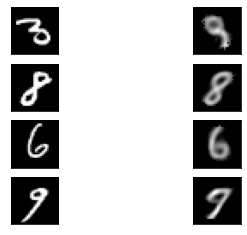

In [87]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg, vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae2(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])

Answer: As already described in the comment present in the notebook, for a latent space of dim(z)=16 the average loss did only change slightly (after epoch 15 0.1541 instead of 01723 before. However, the reconstructed images look clearly better with clearer distinction between the letters.

### Training CVAE
We optimize in the following the CVAE (simpy run the code).

In [92]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]
latent_dim = 2
cvae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim, conditional=True)

cvae = cvae.to(device)
optimizer = optim.Adam(cvae.parameters())


def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = cvae(x, y)
        loss = loss_function(recon_batch, x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    
# Training of CVAE
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 20.398119
Train Epoch: 1 [12800/60000 (21%)]	Loss: 10.927090
Train Epoch: 1 [25600/60000 (43%)]	Loss: 10.454281
Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.771351
Train Epoch: 1 [51200/60000 (85%)]	Loss: 10.007337
====> Epoch: 1 Average loss: 0.1654
Train Epoch: 2 [0/60000 (0%)]	Loss: 9.765146
Train Epoch: 2 [12800/60000 (21%)]	Loss: 9.423344
Train Epoch: 2 [25600/60000 (43%)]	Loss: 9.953191
Train Epoch: 2 [38400/60000 (64%)]	Loss: 9.422255
Train Epoch: 2 [51200/60000 (85%)]	Loss: 10.226418
====> Epoch: 2 Average loss: 0.1529
Train Epoch: 3 [0/60000 (0%)]	Loss: 9.407169
Train Epoch: 3 [12800/60000 (21%)]	Loss: 9.189203
Train Epoch: 3 [25600/60000 (43%)]	Loss: 9.616179
Train Epoch: 3 [38400/60000 (64%)]	Loss: 9.187340
Train Epoch: 3 [51200/60000 (85%)]	Loss: 10.284411
====> Epoch: 3 Average loss: 0.1505
Train Epoch: 4 [0/60000 (0%)]	Loss: 9.138649
Train Epoch: 4 [12800/60000 (21%)]	Loss: 9.094566
Train Epoch: 4 [25600/60000 (43%)]	Loss: 9.513156
Train 

### Sanity Check CVAE
Check whether your CVAE is able to reconstruct certain images when conditioned on the label (simply run the code).
* Is there a difference to the standard VAE?

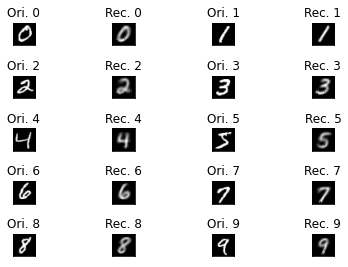

In [93]:
x,l = next(iter(train_loader))
for i in range(0, 10):
    x_one_label = x[l==i][:2]

    samples = x_one_label[:1].to(device)
    labels= i* torch.ones(1).type(torch.long)
    plt.subplot(5,4,2*i+1)
    plt.tight_layout()
    imshow(samples[0,0].cpu())
    plt.title("Ori. {}".format(i))
    
    samples_rec, _, _ = cvae(samples, c = labels)
    samples_rec = samples_rec.detach().cpu().view(-1,28,28)

    plt.subplot(5, 4, 2*i+2)
    plt.tight_layout()
    imshow(samples_rec[0])
    plt.title("Rec. {}".format(i))

Answer: The CVAE is able to reconstruct the digits, but his reconstructions are not a general idealized version, but very similar to the digit instance it was conditioned upon.

Check whether your CVAE is able to generate images from the MNIST dataset distribution by sampling from the latent space and decode these latent codes (simply run the code).
* How do the generated digits compare to those of the VAE?
* Can you imagine why differences could arise?

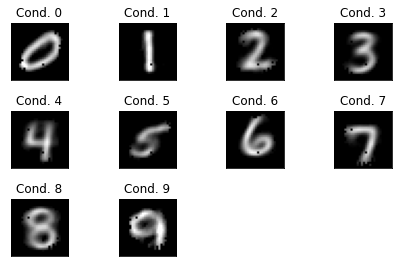

In [94]:
for i in range(0, 10):
    plt.subplot(3,4,i+1)
    label = i* torch.ones(1).type(torch.long)
    sample = cvae.sampling(n=1, c=label).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Cond. {}".format(i))

Answer: It can reconstruct the digits, even with a better resolution than the VAE. Especially the edge cases which were problematic for the VAE (e.g. 8 and 3) are clearly distinguishable here.

This can be attributed to the conditioning nature of the CVAE: Each label class has now an own distribution, which makes things cleaner compared to the vanilla VAE where similar digits (like 8 and 3) are also close together in the latent space.

## Task 2: Visualisation of Latent Space of VAE


### Visualisation of output of decoder
Make sure you use the model vae trained with $2$ latent dimensions.

* Illustrate the 2 dimensional latent space by showing decoder output for different values in the latent space (see example on exercise sheet).

In [ ]:
########
# TODO #
########

### Visualisation of latent space
In the following, you should visualize the latent space directly.
* Make a scatter plot in latent space, where each plotted point represents the latent code of a single image from the MNIST dataset. Color the points according to the image label.
* What kind of shape should ideally arise?
* What do you see in reality?

In [ ]:
########
# TODO #
########

### Weaknesses of the VAE
* Find from your plot coordinates in the latent space that migh cause problems to the VAE if you decode this points. Explain your reasoning.
* Illustrate the decoding of one of these points.
* Describe what you see.

In [ ]:
########
# TODO #
########

## Task 3: Visualisation of Latent Space of CVAE

Make sure you use the model cvae trained with $2$ latent dimensions.

### Visualisation of Latent Space via Decoder

Repeat task 2 for the CVAE: 
* Illustrate the 2 dimensional latent space by showing the output of the decoder for different values in the latent space (see example on exercise sheet).
* Make two or three of these plots, each conditioned on a fixed label.

In [ ]:
########
# TODO #
########

### Visualisation of Latent Space via Decoder
* Repeat the scatter plot from Task 2. For each sample, use the correct label as the condition. Color the points according to the label.
* What difference do you see, compared to the standard VAE?
* How to you explain this?
* What does this mean for 'bad samples', as observed in Task 2?


In [ ]:
########
# TODO #
########

## Task 4: Generative Classifier
We define our classifier as maximum a posteriori estimator and expand according to Bayes rule. The label $\hat y$ for a given ..$x$ is predicted according to:

$$ \hat y= \arg \max_y p(y \mid x) = \arg \max_y \frac{p(x \mid y)p(y)}{p(x)} = \arg \max_y \log p(x \mid y) \ ,$$

where the last identity makes use of the fact that $p(y)=1/10$ is constant for all MNIST labels. We can approximate $\log p(x \mid y)$ in the following way: Given an input image, run the CVAE 10 times, each time conditioning one one of the different class labels $y$. Calculate the losses for each case and use them to design a classifier. Note that the network was never trained as classifier, but is still able to perform the task.  

In [ ]:
########
# TODO #
########